
Analyzing website_data...

Analysis Results for website_data:
Total certificates: 12072
Valid certificates: 2810
Expired certificates: 9262

Expiry Statistics (days):
count     2810.000000
mean       365.659075
std       1332.012419
min          0.000000
25%          6.000000
50%         45.000000
75%         76.000000
max      33612.000000
Name: expiry_days, dtype: float64


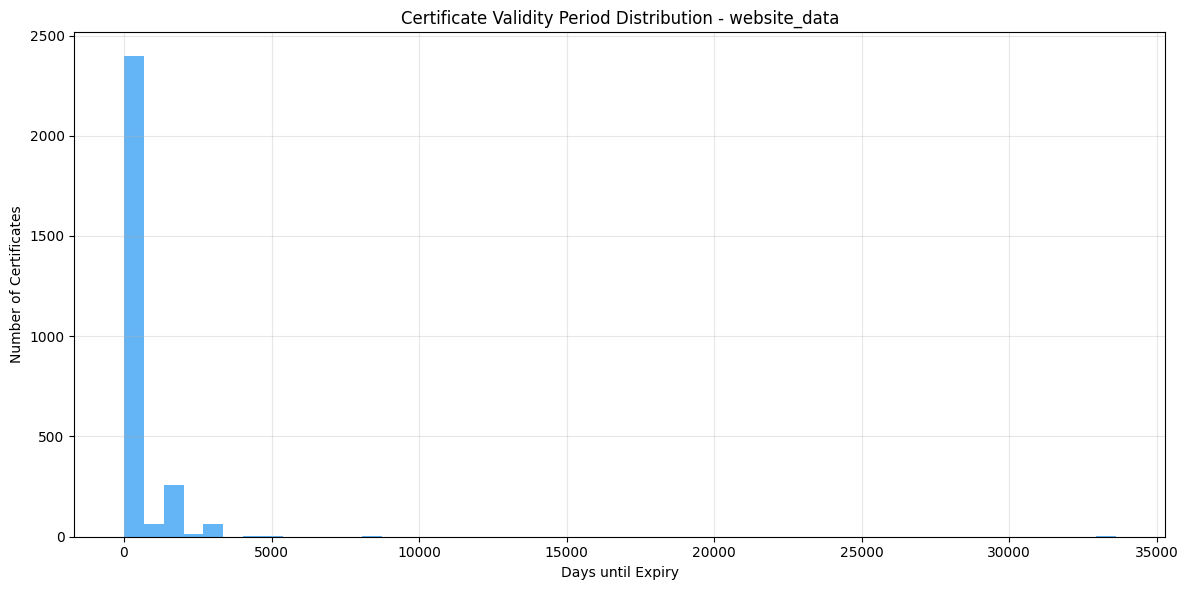

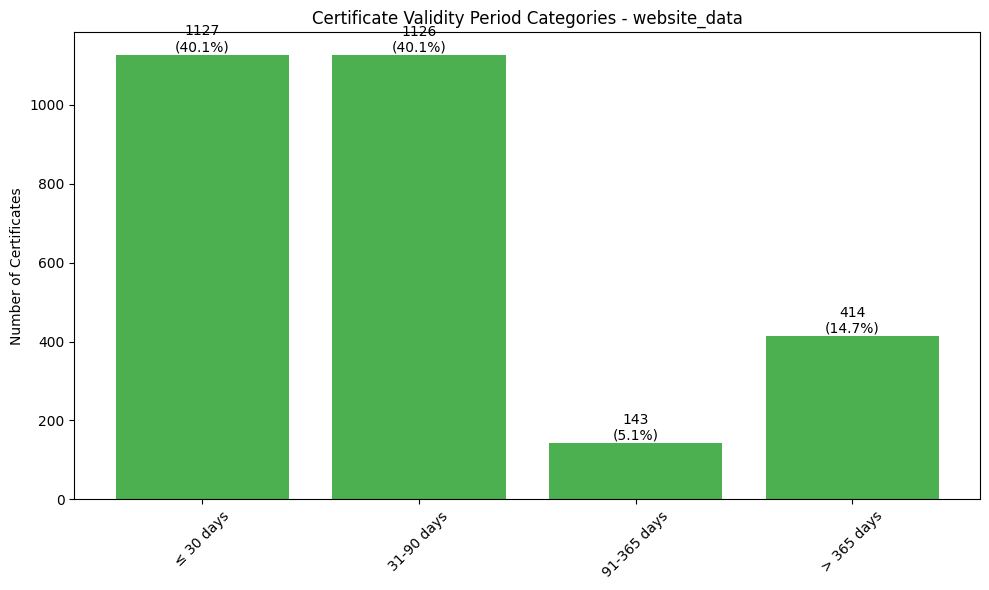


Analyzing normal_sites...

Analysis Results for normal_sites:
Total certificates: 9591
Valid certificates: 3415
Expired certificates: 6176

Expiry Statistics (days):
count    3415.000000
mean      119.298389
std        72.858674
min         0.000000
25%        52.000000
50%       118.000000
75%       180.500000
max       288.000000
Name: expiry_days, dtype: float64


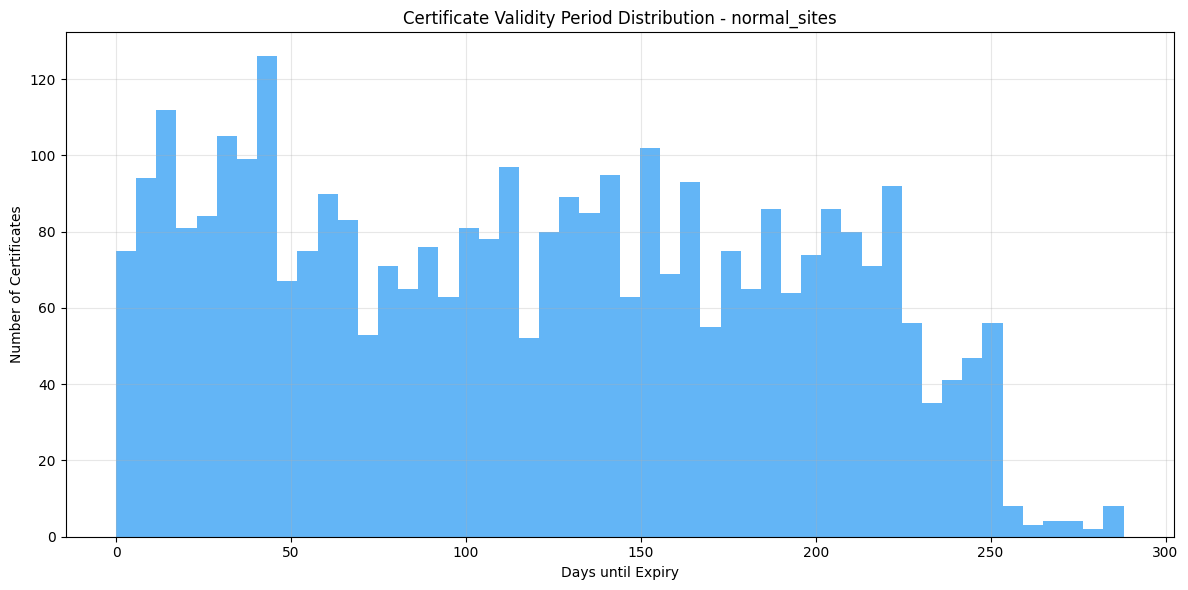

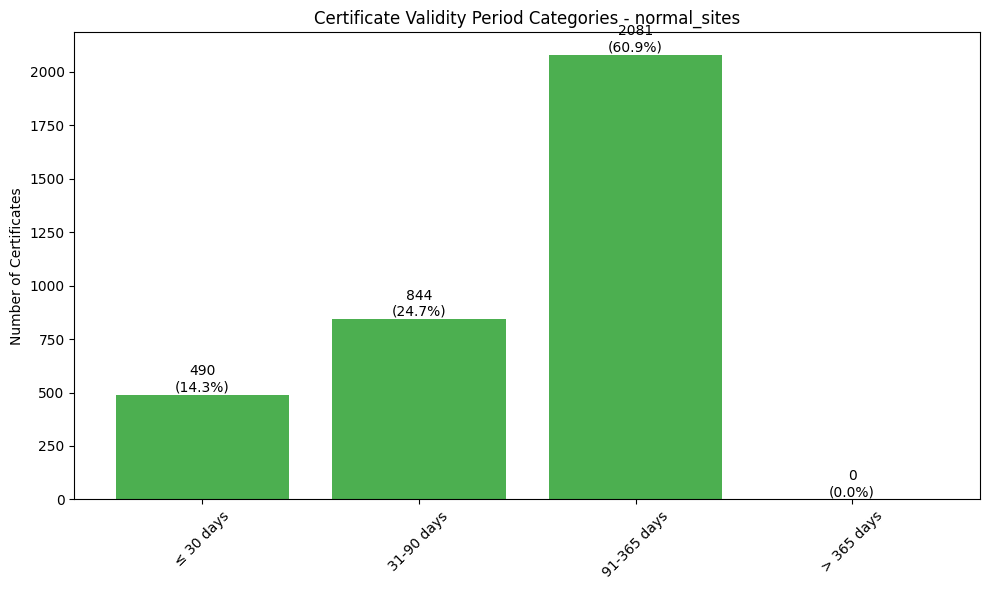

In [1]:
# Program 02: Fixed Certificate Expiry Analysis
# Location: RAPIDS/notebooks/certificate_analysis/02_fixed_certificate_analysis.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import json
from pathlib import Path
import logging
from datetime import datetime
import re
from typing import Optional

class CertificateExpiryAnalyzer:
    def __init__(self, config_path: str = '/home/asomura/waseda/nextstep/RAPIDS/config/database.json'):
        """Initialize the analyzer"""
        self.setup_config(config_path)
        self.setup_logging()
        
    def setup_config(self, config_path: str) -> None:
        """Setup configuration and paths"""
        with open(config_path) as f:
            self.config = json.load(f)['database']
        
    def setup_logging(self) -> None:
        """Setup logging"""
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

    def get_database_connection(self, db_name: str) -> create_engine:
        """Create database connection"""
        host = 'localhost' if db_name == 'website_data' else 'localhost'
        return create_engine(
            f"postgresql://{self.config['user']}:{self.config['password']}@{host}/{db_name}"
        )

    def extract_certificate_data(self, db_name: str) -> pd.DataFrame:
        """Extract certificate data"""
        query = """
        SELECT 
            domain,
            https_certificate_expiry,
            https_certificate_issuer,
            last_update
        FROM website_data 
        WHERE status = 7 
        AND https_certificate_expiry IS NOT NULL
        """
        engine = self.get_database_connection(db_name)
        return pd.read_sql_query(query, engine)

    def parse_expiry_date(self, expiry_text: str) -> Optional[int]:
        """
        Parse certificate expiry date in GeneralizedTime format
        Example format: 20241028073105Z (YYYYMMDDhhmmssZ)
        """
        if pd.isna(expiry_text):
            return None
            
        try:
            # Extract date string using regex
            match = re.search(r'(\d{14})Z', str(expiry_text))
            if match:
                date_str = match.group(1)
                expiry_date = datetime.strptime(date_str, '%Y%m%d%H%M%S')
                days = (expiry_date - datetime.now()).days
                return days
            else:
                self.logger.warning(f"No valid date format found in: {expiry_text}")
                return None
                
        except Exception as e:
            self.logger.error(f"Error parsing date {expiry_text}: {str(e)}")
            return None

    def analyze_expiry(self, df: pd.DataFrame) -> dict:
        """Analyze certificate expiry dates"""
        # Parse expiry dates
        df['expiry_days'] = df['https_certificate_expiry'].apply(self.parse_expiry_date)
        
        # Remove None values and get valid certificates
        valid_certs = df[df['expiry_days'].notna()]
        valid_certs = valid_certs[valid_certs['expiry_days'] >= 0]
        
        # Calculate statistics
        stats = {
            'total_certs': len(df),
            'valid_certs': len(valid_certs),
            'expiry_stats': valid_certs['expiry_days'].describe(),
            'expired_count': len(df[df['expiry_days'] < 0]) if 'expiry_days' in df else 0,
        }
        
        return stats, valid_certs

    def plot_expiry_distribution(self, valid_certs: pd.DataFrame, db_name: str) -> None:
        """Plot expiry date distribution"""
        plt.figure(figsize=(12, 6))
        
        # Create histogram with reasonable bins
        plt.hist(valid_certs['expiry_days'], bins=50, color='#2196F3', alpha=0.7)
        plt.title(f'Certificate Validity Period Distribution - {db_name}')
        plt.xlabel('Days until Expiry')
        plt.ylabel('Number of Certificates')
        
        # Add grid
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Create period breakdown
        periods = {
            '≤ 30 days': (valid_certs['expiry_days'] <= 30).sum(),
            '31-90 days': ((valid_certs['expiry_days'] > 30) & (valid_certs['expiry_days'] <= 90)).sum(),
            '91-365 days': ((valid_certs['expiry_days'] > 90) & (valid_certs['expiry_days'] <= 365)).sum(),
            '> 365 days': (valid_certs['expiry_days'] > 365).sum()
        }
        
        # Plot period breakdown
        plt.figure(figsize=(10, 6))
        plt.bar(periods.keys(), periods.values(), color='#4CAF50')
        plt.title(f'Certificate Validity Period Categories - {db_name}')
        plt.xticks(rotation=45)
        plt.ylabel('Number of Certificates')
        
        # Add value labels
        total = sum(periods.values())
        for i, (period, count) in enumerate(periods.items()):
            percentage = count / total * 100
            plt.text(i, count, f'{count}\n({percentage:.1f}%)', 
                    ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

def main():
    analyzer = CertificateExpiryAnalyzer()
    
    for db_name in ['website_data', 'normal_sites']:
        print(f"\nAnalyzing {db_name}...")
        
        try:
            # Get and analyze data
            df = analyzer.extract_certificate_data(db_name)
            stats, valid_certs = analyzer.analyze_expiry(df)
            
            # Print results
            print(f"\nAnalysis Results for {db_name}:")
            print(f"Total certificates: {stats['total_certs']}")
            print(f"Valid certificates: {stats['valid_certs']}")
            print(f"Expired certificates: {stats['expired_count']}")
            
            print("\nExpiry Statistics (days):")
            print(stats['expiry_stats'])
            
            # Create visualizations
            if len(valid_certs) > 0:
                analyzer.plot_expiry_distribution(valid_certs, db_name)
            else:
                print("No valid certificates found for visualization")
            
        except Exception as e:
            print(f"Error analyzing {db_name}: {str(e)}")

if __name__ == "__main__":
    main()